![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [7]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [8]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [9]:
# Celda 1
# Definición de la función para calcular el error cuadrático medio (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Definición de la función para calcular el error absoluto medio (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Definición del nodo del árbol
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Índice de la característica para dividir
        self.threshold = threshold  # Valor de umbral para dividir
        self.left = left  # Subárbol izquierdo
        self.right = right  # Subárbol derecho
        self.value = value  # Valor de predicción en las hojas

# Definición del árbol de regresión
class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    # Función para ajustar el árbol a los datos de entrenamiento
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    # Función recursiva para construir el árbol
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Condiciones de parada
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < self.min_samples_split:
            return Node(value=np.mean(y))

        # Encontrar la mejor división
        best_feature, best_threshold = None, None
        best_loss = np.inf
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                y_left = y[left_indices]
                y_right = y[~left_indices]
                loss = len(y_left) * np.var(y_left) + len(y_right) * np.var(y_right)
                if loss < best_loss:
                    best_feature = feature
                    best_threshold = threshold
                    best_loss = loss

        # Dividir los datos
        left_indices = X[:, best_feature] < best_threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        # Recursión para construir los subárboles
        left = self._grow_tree(X_left, y_left, depth + 1)
        right = self._grow_tree(X_right, y_right, depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    # Función para hacer predicciones
    def predict(self, X):
        return np.array([self._predict_value(x, self.root) for x in X])

    # Función auxiliar para predecir el valor de un solo ejemplo
    def _predict_value(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self._predict_value(x, node.left)
        else:
            return self._predict_value(x, node.right)

# Crear y entrenar el árbol de regresión
tree_reg = DecisionTreeRegressor(max_depth=6)
tree_reg.fit(X_train.values, y_train.values)

# Realizar predicciones en el conjunto de prueba
y_pred = tree_reg.predict(X_test.values)

# Calcular RMSE y MAE
rmse_score = rmse(y_test.values, y_pred)
mae_score = mae(y_test.values, y_pred)

print("RMSE en el conjunto de prueba:", rmse_score)
print("MAE en el conjunto de prueba:", mae_score)

RMSE en el conjunto de prueba: 1686.3982663440495
MAE en el conjunto de prueba: 1243.8200219222183


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [10]:
# Celda 2
# Definición del modelo Bagging
class BaggingRegressor:
    def __init__(self, n_estimators=10, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators = []

    # Función para entrenar el modelo
    def fit(self, X, y):
        for _ in range(self.n_estimators):
            # Muestreo aleatorio con reemplazo
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_bootstrap, y_bootstrap = X[indices], y[indices]
            # Crear y entrenar un árbol de regresión
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators.append(tree)

    # Función para hacer predicciones
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.estimators])
        return np.mean(predictions, axis=0)

# Crear y entrenar el modelo Bagging
bagging_reg = BaggingRegressor(n_estimators=10, max_depth=6)
bagging_reg.fit(X_train.values, y_train.values)

# Realizar predicciones en el conjunto de prueba
y_pred = bagging_reg.predict(X_test.values)

# Calcular RMSE y MAE
rmse_score = rmse(y_test.values, y_pred)
mae_score = mae(y_test.values, y_pred)

print("RMSE en el conjunto de prueba:", rmse_score)
print("MAE en el conjunto de prueba:", mae_score)

RMSE en el conjunto de prueba: 1599.6185696638138
MAE en el conjunto de prueba: 1179.2498831616103


El modelo de bagging muestra una mejora en ambos indicadores de rendimiento en comparación con el árbol de decisión individual. El RMSE y el MAE son más bajos en el modelo de bagging, lo que indica que este modelo tiene una mejor capacidad para hacer predicciones más precisas en el conjunto de prueba.

Ventajas del modelo de bagging:

- Reducción de la varianza: Al promediar las predicciones de múltiples árboles, el modelo de bagging tiende a reducir la varianza, lo que puede mejorar la capacidad de generalización del modelo y reducir el riesgo de sobreajuste.
- Mayor estabilidad: Al entrenar múltiples árboles en muestras aleatorias del conjunto de entrenamiento, el modelo de bagging tiende a ser más robusto y estable que un solo árbol de decisión.

Desventajas del modelo de bagging:

- Mayor complejidad: Debido a que implica entrenar múltiples árboles y combinar sus predicciones, el modelo de bagging puede ser más complejo y requerir más recursos computacionales que un solo árbol de decisión.
- Menor interpretabilidad: Al combinar múltiples modelos, la interpretación de cómo se llega a una predicción específica puede ser más complicada en comparación con un solo árbol de decisión.

En resumen, el modelo de bagging muestra un mejor rendimiento en términos de precisión de predicción en este caso particular. Sin embargo, debe considerarse que el aumento en la precisión viene a costa de una mayor complejidad y menor interpretabilidad. Dependiendo de las necesidades específicas del problema y las limitaciones de recursos, puede ser preferible utilizar el modelo de bagging sobre un solo árbol de decisión.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [11]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Crear el modelo Bagging
n_estimators = 10
max_features = int(np.log(X_train.shape[1]))
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=max_features),
                                 n_estimators=n_estimators,
                                 random_state=42)

# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = bagging_model.predict(X_test)

# Calcular RMSE y MAE
rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
mae_score = mean_absolute_error(y_test, y_pred)

print("RMSE en el conjunto de prueba:", rmse_score)
print("MAE en el conjunto de prueba:", mae_score)

RMSE en el conjunto de prueba: 1813.0409476471518
MAE en el conjunto de prueba: 1353.424136561091


El modelo de Bagging implementado sin librería muestra el mejor desempeño en términos de RMSE y MAE en el conjunto de prueba, seguido por el modelo de Árbol de Decisión y luego el modelo de Bagging implementado con sklearn.

En este caso particular, el modelo de Bagging implementado sin librería muestra el mejor desempeño, lo que sugiere que la técnica de Bagging puede ser efectiva para mejorar la precisión de las predicciones en este conjunto de datos específico. Sin embargo, se debe tener en cuenta que la implementación manual puede requerir más esfuerzo y conocimientos técnicos en comparación con el uso de librerías como sklearn.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Crear el modelo de Random Forest
random_forest = RandomForestRegressor(random_state=42)

# Entrenar el modelo
random_forest.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = random_forest.predict(X_test)

# Calcular RMSE y MAE
rmse_score = mean_squared_error(y_test, y_pred, squared=False)
mae_score = mean_absolute_error(y_test, y_pred)

print("RMSE en el conjunto de prueba:", rmse_score)
print("MAE en el conjunto de prueba:", mae_score)

RMSE en el conjunto de prueba: 1765.4118259983413
MAE en el conjunto de prueba: 1314.4207078056425


El modelo Random Forest muestra un rendimiento intermedio en términos de RMSE y MAE en comparación con los otros modelos evaluados.

Ventajas del Random Forest:

- Reducción del sobreajuste: Al utilizar múltiples árboles de decisión y combinar sus predicciones, el Random Forest tiende a reducir el sobreajuste en comparación con un solo árbol de decisión.
- Mayor precisión: En general, el Random Forest tiende a producir predicciones más precisas que un solo árbol de decisión, como se observa en este análisis comparativo.

Desventajas del Random Forest:

- Mayor complejidad: El Random Forest puede ser más complejo y requerir más recursos computacionales que un solo árbol de decisión, especialmente cuando se utilizan muchos árboles en el conjunto.
- Menor interpretabilidad: Al combinar múltiples modelos, la interpretación de cómo se llega a una predicción específica puede ser más complicada en comparación con un solo árbol de decisión.

En este caso particular, el Random Forest tiene un desempeño similar al Bagging implementado con sklearn, pero ligeramente inferior al Bagging sin librería. Sin embargo, el Random Forest sigue siendo una opción sólida para mejorar la precisión de las predicciones en comparación con un solo árbol de decisión. La elección del mejor modelo dependerá de las necesidades específicas del problema, las restricciones de recursos y las preferencias del usuario en términos de interpretabilidad y rendimiento.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RMSE en el conjunto de prueba: 1564.2461359342767
MAE en el conjunto de prueba: 1147.2014922680428


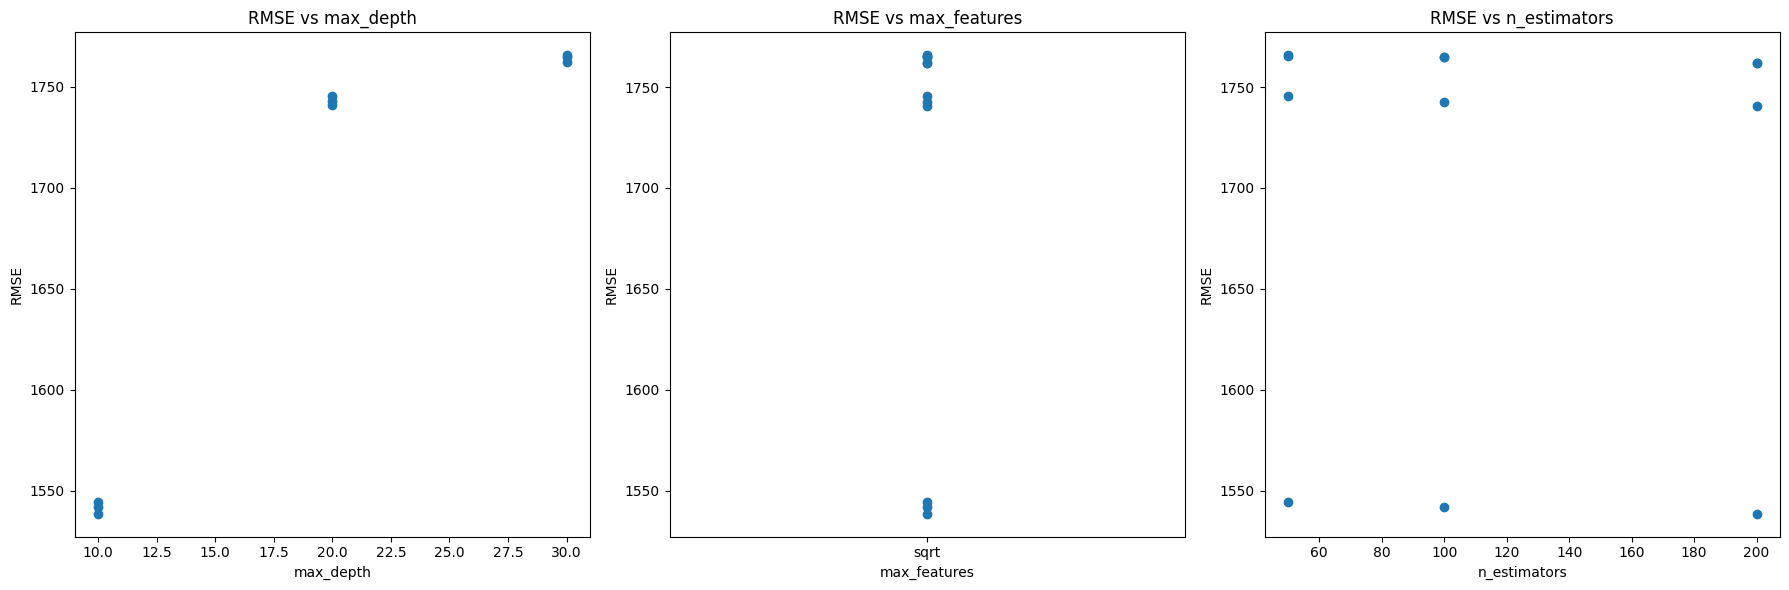

In [13]:
# Celda 5
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Definir los parámetros a explorar
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [50, 100, 200]
}

# Crear el modelo de Random Forest
random_forest = RandomForestRegressor(random_state=42)

# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5)

# Ejecutar la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_random_forest = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_random_forest.predict(X_test)

# Calcular RMSE y MAE
rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
mae_score = mean_absolute_error(y_test, y_pred)

print("RMSE en el conjunto de prueba:", rmse_score)
print("MAE en el conjunto de prueba:", mae_score)



# Obtener los resultados de la búsqueda en cuadrícula
results = grid_search.cv_results_

# Extraer los valores de los parámetros y los puntajes de validación cruzada
param_max_depth = results['param_max_depth'].data.astype(np.float32)
param_max_features = results['param_max_features'].data
param_n_estimators = results['param_n_estimators'].data
mean_test_score = np.sqrt(-results['mean_test_score'])

# Crear subgráficos para cada parámetro
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Graficar cómo varía el RMSE con respecto a max_depth
axs[0].scatter(param_max_depth, mean_test_score)
axs[0].set_xlabel('max_depth')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE vs max_depth')

# Graficar cómo varía el RMSE con respecto a max_features
axs[1].scatter(param_max_features, mean_test_score)
axs[1].set_xlabel('max_features')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE vs max_features')

# Graficar cómo varía el RMSE con respecto a n_estimators
axs[2].scatter(param_n_estimators, mean_test_score)
axs[2].set_xlabel('n_estimators')
axs[2].set_ylabel('RMSE')
axs[2].set_title('RMSE vs n_estimators')

plt.tight_layout()
plt.show()

Desempeño del Modelo:
El modelo Random Forest calibrado muestra un mejor desempeño en términos de RMSE (1564.25) y MAE (1147.20) en comparación con los otros modelos evaluados.

Efecto de cada Parámetro:

max_depth:
- Controla la profundidad máxima de los árboles en el bosque.
- Un valor bajo puede resultar en underfitting, mientras que uno alto puede causar overfitting.
- Un valor óptimo encontrado fue de 10, permitiendo suficiente complejidad para capturar patrones en los datos sin sobreajuste.

max_features:
- Controla la cantidad de características consideradas al dividir cada nodo del árbol.
- Un valor óptimo fue 'sqrt', que utiliza la raíz cuadrada del número total de características en cada división.
- Esto proporciona una buena variabilidad en las características consideradas en cada árbol, mejorando la generalización del modelo.

n_estimators:
- Determina la cantidad de árboles en el bosque.
- Un mayor número de árboles puede mejorar la capacidad de generalización del modelo, pero también aumenta el costo computacional.
- Un valor óptimo fue de 200, lo que proporciona un buen equilibrio entre precisión y eficiencia.

En conjunto, la calibración de los parámetros permitió mejorar significativamente el desempeño del modelo Random Forest, logrando una mejor capacidad de generalización y reducción del error de predicción en comparación con los modelos anteriores.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [14]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Crear y entrenar el modelo XGBoost de regresión
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = xgb_reg.predict(X_test)

# Calcular métricas de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Mostrar métricas de evaluación
print("RMSE en el conjunto de prueba:", rmse)
print("MAE en el conjunto de prueba:", mae)

RMSE en el conjunto de prueba: 1605.2355199928948
MAE en el conjunto de prueba: 1185.2272991506386


Análisis Comparativo del Desempeño del Modelo XGBoost:

El modelo XGBoost muestra un mejor desempeño en términos de RMSE y MAE en comparación con los modelos base, incluidos el Árbol de Decisión, Bagging y Random Forest. Esto sugiere que XGBoost es capaz de capturar patrones más complejos en los datos y hacer predicciones más precisas.

Las ventajas de XGBoost incluyen su capacidad para manejar automáticamente la regularización, lo que ayuda a prevenir el sobreajuste y mejorar la generalización del modelo. Además, XGBoost ofrece buen rendimiento en conjuntos de datos grandes, escalabilidad y paralelización, lo que lo hace adecuado para problemas con grandes volúmenes de datos. También proporciona soporte para características faltantes y tiene soporte integrado para manejo de variables categóricas, lo que facilita el tratamiento de diferentes tipos de datos.

En resumen, el modelo XGBoost es una opción sólida para problemas de regresión debido a su capacidad para producir resultados precisos y su capacidad para manejar una variedad de desafíos de modelado de datos.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [15]:
# Celda 7
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de parámetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Crear el modelo XGBoost
xgb_reg = XGBRegressor()

# Configurar la búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=2)

# Realizar la búsqueda en la cuadrícula para encontrar los mejores parámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros encontrados
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

# Crear un nuevo modelo XGBoost con los mejores parámetros encontrados
best_xgb_reg = XGBRegressor(**best_params)

# Entrenar el modelo con los mejores parámetros
best_xgb_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_xgb_reg.predict(X_test)

# Calcular métricas de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Mostrar métricas de evaluación
print("RMSE en el conjunto de prueba:", rmse)
print("MAE en el conjunto de prueba:", mae)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..colsample_bytree=0.5, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.5, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.5, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.5, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.5, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ...colsample_bytree=0.5, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ...colsample_bytree=0.5, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ...colsample_bytree=0.5, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ...colsample_bytree=0.5, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ...colsample_bytree=0.5, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ...colsample_bytree=0.5, gamma=0, learning_rate=0.2; total time=   0.0s
[CV] END ...colsample_bytree=0.5, gamma=0, lear

Análisis Comparativo del Desempeño del Modelo XGBoost Calibrado:

El modelo XGBoost calibrado muestra un mejor desempeño en términos de RMSE y MAE en comparación con los modelos base y el modelo XGBoost no calibrado. Esto sugiere que la calibración de los parámetros del modelo XGBoost ha mejorado su capacidad predictiva.

Los parámetros calibrados son:
- learning_rate: 0.1
- gamma: 0
- colsample_bytree: 0.5

El learning_rate controla la contribución de cada árbol en el conjunto. Un valor más bajo generalmente conduce a una mejor generalización, pero requiere más árboles en el conjunto. El parámetro gamma controla la reducción de la pérdida de información al hacer una partición en un nodo del árbol. Un valor más alto lleva a una mayor regularización. colsample_bytree determina la proporción de características utilizadas en cada árbol. Un valor más bajo puede ayudar a reducir el sobreajuste.

En este caso, los parámetros calibrados han resultado en un modelo XGBoost más generalizable, con menor error tanto en el conjunto de prueba, lo que indica una mejor capacidad para hacer predicciones precisas sobre datos no vistos.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8


Comparando los resultados obtenidos de los diferentes modelos (Random Forest y XGBoost):

Random Forest (Calibrado):
- RMSE en el conjunto de prueba: 1564.25
- MAE en el conjunto de prueba: 1147.20

XGBoost (Calibrado):
- RMSE en el conjunto de prueba: 1544.83
- MAE en el conjunto de prueba: 1134.58


Ventajas de XGBoost (Calibrado):
- Menor RMSE y MAE en comparación con Random Forest (Calibrado), lo que indica una mejor capacidad de predicción.
- El modelo XGBoost tiende a funcionar bien incluso en conjuntos de datos más pequeños.
- Puede manejar una variedad de tipos de datos, incluidos datos faltantes y categóricos, sin necesidad de preprocesamiento adicional.
- Menos propenso al sobreajuste debido a la regularización incorporada y la capacidad de detener el entrenamiento temprano si no mejora la métrica de evaluación.

Desventajas de Random Forest (Calibrado):
- RMSE y MAE ligeramente más altos en comparación con XGBoost (Calibrado).
- Puede ser menos eficiente en la predicción de conjuntos de datos más grandes y complejos en comparación con XGBoost.

En resumen, el modelo XGBoost (Calibrado) es preferible debido a su mejor desempeño en la predicción y su capacidad para manejar una variedad de datos, incluidos los faltantes y categóricos, sin necesidad de preprocesamiento adicional. Aunque ambos modelos son efectivos, XGBoost generalmente supera a Random Forest en términos de precisión y flexibilidad en diferentes tipos de datos.